# Scraper Development

## 1. Import Packages

In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import jieba
from collections import Counter
import kaleido
import plotly.io as pio
pio.renderers.default = "png"

## 2. Send Requests

In [ ]:
'''
date(v0):March 10 2025
@ author: Susan Sun
-function: send requests to any given url
-parameters:  
    - url: given link to scrape from
-return: 
    - soup: all the information on the page
'''
def send_request(url): 
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}
    reponse = requests.get(url=url,headers=headers)
    soup = BeautifulSoup(reponse.content,"html.parser")
    return soup

## 3. Inspect results

### 3.1 General Video Information

In [ ]:
'''
date: March 10 2025
@ author: Susan Sun
-function: extract general video information, including titles, authors, durations, and links
-parameters: 
    - soup: from the request (all the information on the page)
-return:
    - general_info: pandas DataFrame containing four general info
'''
def get_general_info(soup):
    items = soup.find_all("div",class_="bili-video-card__info")
    titles = pd.DataFrame([],columns=["Title"])
    ups = pd.DataFrame([],columns=["Up"])
    links = pd.DataFrame([],columns=["Link"])

    for i in items:
        title = i.find("h3",class_="bili-video-card__info--tit").text
        title = pd.DataFrame([title],columns=["Title"])
   
        up = i.find("span",class_="bili-video-card__info--author").text
        up = pd.DataFrame([up],columns=["Up"])
       
        link = "https:" + i.find("a")["href"]
        link = pd.DataFrame([link],columns=["Link"])

        titles = pd.concat([titles,title],ignore_index=True)
        ups = pd.concat([ups,up],ignore_index=True)
        links = pd.concat([links,link],ignore_index=True)

    general_info = pd.concat([titles,ups,links],axis=1,ignore_index=False)

    '''GET DURATION'''
    items2 = soup.find_all("div",class_="bili-video-card__stats")

    durations = pd.DataFrame([],columns=["Duration"])
    for i in items2:
        duration = i.find("span",class_="bili-video-card__stats__duration").text
        duration = pd.DataFrame([duration],columns=["Duration"])
        durations = pd.concat([durations,duration],ignore_index=True)

    general_info = pd.concat([general_info,durations],axis=1,ignore_index=False)
   
    return general_info

### 3.2 Interactive Information

In [ ]:
'''
date: March 10 2025
@ author: Susan Sun
-function: extract interactive information, including likes, coins, favs, shares, views, dms, and pubdates
-parameters:
    - general_info (output from get_general_info, we need links form it)
-return:
    - interact_info: a pandas DataFrame containing six audiences interactive information. Plus, pubdates in correct format.
'''
def get_interact_info(general_info):

    '''初始化'''
    likes = pd.DataFrame([],columns=["点赞量"])
    coins = pd.DataFrame([], columns=["投币量"])
    favs = pd.DataFrame([], columns=["收藏量"])
    shares = pd.DataFrame([], columns=["转发量"])
    views = pd.DataFrame([], columns=["播放量"])
    dms = pd.DataFrame([], columns=["弹幕量"])
    pubdates = pd.DataFrame([],columns=["发布时间"])
    
    for www in general_info["Link"]:
        url = www
        headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}
        reponse = requests.get(url=url,headers=headers)
        soup = BeautifulSoup(reponse.content,"html.parser")
        
        '''对应每一类不同信息的位置'''
        #1.1：点赞的位置
        like = soup.find_all("div",class_="video-like video-toolbar-left-item")
        #2.1：投币量的位置
        coin = soup.find_all('div', class_="video-coin video-toolbar-left-item")
        #3.1：收藏量的位置
        fav = soup.find_all('div', class_="video-fav video-toolbar-left-item")
        #4.1：转发量的位置
        share = soup.find_all('div', class_="video-share-wrap video-toolbar-left-item")
        #5.1: 播放量的数量
        view = soup.find_all("div",class_="view item")
        #6.1: 弹幕量的数量
        dm = soup.find_all("div",class_="dm item")
        #7.1：投稿时间
        pubdate = soup.find_all("div",class_="pubdate-ip item")
        
        '''收集对应每一类的数量'''
        #1.2：点赞量的数量
        for l in like:
            l = l.find("span",class_="video-like-info video-toolbar-item-text").text
            l = pd.DataFrame([l],columns=["点赞量"])
        #2.2: 投币的数量
        for c in coin:
            c = c.find("span", class_="video-coin-info video-toolbar-item-text").text
            c = pd.DataFrame([c],columns=["投币量"])
        #3.2：收藏的数量
        for f in fav:
            f = f.find("span", class_="video-fav-info video-toolbar-item-text").text
            f = pd.DataFrame([f],columns=["收藏量"])  
        #4.1：转发量的位置
        share = soup.find_all('div', class_="video-share-wrap video-toolbar-left-item")
        for s in share:
            s = s.find("span", class_="video-share-info video-toolbar-item-text").text
            s = pd.DataFrame([s],columns=["转发量"]) 
        #5.2: 播放量的位置
        for v in view:
            v = v.find("div",class_="view-text").text
            v = pd.DataFrame([v],columns=["播放量"])
        #6.2: 弹幕量的位置
        for d in dm:
            d = d.find("div",class_="dm-text").text
            d = pd.DataFrame([d],columns=["弹幕量"])
        #7.2: 发布时间的位置
        for p in pubdate:
            p = p.find("div",class_="pubdate-ip-text")
            p = pd.DataFrame([p],columns=["发布时间"])
            
        '''添加到数据集'''
        likes = pd.concat([likes,l],ignore_index=True)
        coins = pd.concat([coins,c],ignore_index=True)
        favs = pd.concat([favs,f],ignore_index=True)
        shares = pd.concat([shares,s],ignore_index=True)
        views = pd.concat([views,v],ignore_index=True)
        dms = pd.concat([dms,d],ignore_index=True)
        pubdates = pd.concat([pubdates,p],ignore_index=True)
    
    '''合并7个数据集'''
    interact_info = pd.concat([likes,coins,favs,shares,views,dms,pubdates],axis=1,ignore_index=False)
        
    return interact_info

## 4. Wrap Results

In [ ]:
'''
-----run all functions-----
1. send_request (url) ---> soup
2. get_general_info (soup) ---> general_info
3. get_interact_info (general_info) ---> interact_info
4. all_info = pd.concat([2,3])
'''

base = "https://search.bilibili.com/all?keyword=非遗木雕&page="
urls = [base + str (page) for page in range (1,35)]

#initialize of blank dataframe of all pages
culture_heritage_video = pd.DataFrame ()
print ("> > > running scraper for cultural heritage video data...")
pg = 1
for url in urls:
    #1. send request: 
    soup = send_request (url)
    #2. get general info based on soup
    general_info = get_general_info (soup)
    #3. get interactive info based on general info
    interact_info = get_interact_info (general_info)
    #4. merge all
    all_info = pd.concat([general_info, interact_info], axis=1, ignore_index=False)
    culture_heritage_video = pd.concat([culture_heritage_video, all_info], axis=0, ignore_index=True)
    print ("videos on Page " + str (pg) + " saved.")
    pg += 1

#5. output as CSV
culture_heritage_video.to_csv('culture_heritage_video.csv', index=False, header= True)
print ("> > > all 34 pages have been saved in the csv.")

In [ ]:
base = "https://search.bilibili.com/all?keyword=非遗木雕&page="

# Data Analysis
## 1. Data Cleaning

In [3]:
raw_data = pd.read_csv("culture_heritage_video.csv")
raw_data.sample(5)

,Title,Up,Link,Duration,点赞量,投币量,收藏量,转发量,播放量,弹幕量,发布时间
16,非遗木雕技艺——传承与创新,是秋秋秋秋秋啊,https://www.bilibili.com/video/BV1LMtPewEv7/,03:45,2,2,2,3,154,0,2024-09-14 07:37:31
511,跟我一起做你的人生第一个木雕~哇酷哇酷,刁刻岛,https://www.bilibili.com/video/BV1KkQJYqE5A/,01:56,3946,126,1004,47,5.8万,38,2025-03-12 12:58:20
391,【木雕教学】要避免的 5 个初学者削减错误！,手艺人鲁班班,https://www.bilibili.com/video/BV1id4y1g7a3/,07:04,214,8,302,14,1.4万,10,2022-09-19 16:27:26
505,【非遗绒花】中式传统红配绿俗？我想你没见过这支花,慕容意的手工小记,https://www.bilibili.com/video/BV1gB4y1Q7qX/,02:06,5.1万,3644,2.1万,510,202.7万,322,2022-06-06 20:20:05
192,《祥雲》——纯手工雕刻全过程,雕刻师何同学,https://www.bilibili.com/video/BV1y7qZYTEmy/,01:00,129,11,133,8,2336,0,2024-12-15 16:33:41


In [5]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Title     1000 non-null   object
 1   Up        1000 non-null   object
 2   Link      1000 non-null   object
 3   Duration  1000 non-null   object
 4   点赞量       1000 non-null   object
 5   投币量       1000 non-null   object
 6   收藏量       1000 non-null   object
 7   转发量       1000 non-null   object
 8   播放量       1000 non-null   object
 9   弹幕量       1000 non-null   object
 10  发布时间      1000 non-null   object
dtypes: object(11)
memory usage: 86.1+ KB


### 1.1 Filter irrelevant contents

In [8]:
raw_data = raw_data[raw_data["Title"].str.contains("木雕")]

### 1.2 Clean abnormal values

In [11]:
'''Syntax: df.loc[df[column]=="点赞", 被替换列的名字] = 新的值'''
raw_data.loc[raw_data["点赞量"] == "点赞", "点赞量"] = "0"
raw_data.loc[raw_data["投币量"] == "投币", "投币量"] = "0"
raw_data.loc[raw_data["收藏量"] == "收藏", "收藏量"] = "0"
raw_data.loc[raw_data["转发量"] == "分享", "转发量"] = "0"

### 1.3 Drop duplicates

In [14]:
raw_data = raw_data.drop_duplicates().reset_index(drop=True)
raw_data.shape

(424, 11)

### 1.4 Standardize units

In [17]:
raw_data["点赞量"] = raw_data["点赞量"].apply(lambda x: int (float (x [:-1])*10000) if "万" in x else int(x))
raw_data["投币量"] = raw_data["投币量"].apply(lambda x: int (float (x [:-1])*10000) if "万" in x else int (x))
raw_data["收藏量"] = raw_data["收藏量"].apply(lambda x : int (float (x [:-1])*10000) if "万" in x else int (x))
raw_data["转发量"] = raw_data["转发量"].apply(lambda x : int (float (x [:-1])*10000) if "万" in x else int (x))
raw_data["播放量"]= raw_data["播放量"].apply(lambda x : int (float (x [:-1])*10000) if "万" in x else int (x))
raw_data["弹幕量"]= raw_data["弹幕量"].apply(lambda x : int (float (x [:-1])*10000) if "万" in x else int (x))

### 1.5 Unify data types

In [20]:
'''
date: March 24 2025
@ author: Susan Sun
-function: convert time of different formats into seconds
-parameters:
    - x: a string (format1: hh:mm:ss or format2: mm:ss)
-return:
    - second: int number of second
'''
def hms_to_sec(x):
    hms = x.split(":")
    # mm:ss
    if len(hms) == 2:
        sec = int (hms[-2])*60 + int (hms [-1])
    # hh:mm:ss
    else: 
        sec = int (hms[-3])*3600 + int (hms [-2])*60 + int (hms [-1])
    return sec

In [22]:
second = raw_data["Duration"].apply(lambda x: hms_to_sec(x))
raw_data.insert(4, "Duration_sec", second)

## 2 Feature Engineering

### 2.1 Generate New Features: Published Year and Month

In [26]:
raw_data["发布时间"] = pd.to_datetime(raw_data["发布时间"])
# extract year from date
raw_data["Publish Year"] = raw_data["发布时间"].dt.year
raw_data["Publish Month"] = raw_data["发布时间"].dt.month

### 2.2 Generate New Features: Recommend Rate
- Calculate recommend rate based on metrics of audience interactions and the platform recommend algorithm.
- $$rec\ rate = share \times0.6 + coin \times0.4 + like \times0.4 + Danmu \times0.4 + fav \times0.3 + view \times0.25$$
- When the view less than the 10/3 times recommend rate the platform will recommend.

In [29]:
raw_data["recommend_rate"] = (10/3)*(raw_data["转发量"]*0.6 + raw_data["投币量"]*0.4 + raw_data["点赞量"]*0.4 + raw_data["弹幕量"]*0.4 + raw_data["收藏量"]*0.3 + raw_data["播放量"]*0.25)

In [31]:
raw_data.sample (3)

,Title,Up,Link,Duration,Duration_sec,点赞量,投币量,收藏量,转发量,播放量,弹幕量,发布时间,Publish Year,Publish Month,recommend_rate
398,【木雕】神奇！如何四分钟在木头上雕出一朵小花来！,卞九,https://www.bilibili.com/video/BV1qx411m7Xh/,04:13,253,50,128,682,40,34000,135,2017-05-07 21:34:30,2017,5,29512.666667
37,《非遗中国·重庆瑰宝》第19集：奉节阴沉木雕,非遗小当家,https://www.bilibili.com/video/BV1Cx411i7Wy/,15:00,900,15,5,67,45,2030,1,2017-07-22 19:45:12,2017,7,1876.666667
131,《黑神话：悟空》——我如何在15天内用精湛技艺/手艺雕刻出孙悟空木雕,越南木雕小哥Duy,https://www.bilibili.com/video/BV1Bvi9YLE2Q/,11:45,705,425,154,94,20,8414,11,2024-12-06 11:42:00,2024,12,7932.333333


## 3 Exploratory Data Analysis

### 3.1 Relationship Between Video Duration and Likes

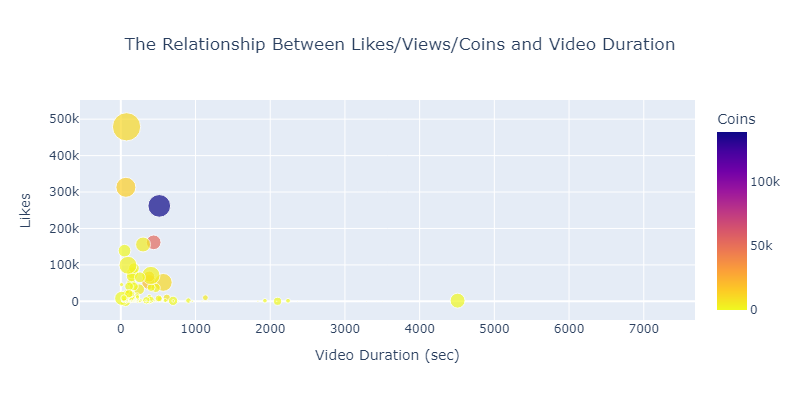

In [35]:
fig1 = px.scatter (
    data_frame = raw_data,
    x = "Duration_sec", 
    y = "点赞量",
    size = "播放量",
    color = "投币量", color_continuous_scale=px.colors.sequential.Plasma_r,
    title = "The Relationship Between Likes/Views/Coins and Video Duration",
    labels = {"投币量":"Coins"},
    hover_data = ["Title", "Up", "Duration"]
)
fig1.update_layout (
    width = 800, height = 400,
    xaxis_title = "Video Duration (sec)", yaxis_title = "Likes",
    title_x = 0.5
)
fig1.show('png')

### Finding:
1. The **most popular** about wood carving culture got <u/>479K likes, 3.65M views, and 11K coins</u>. The result indicates that the group who is interested in wood carving culture is larger than expected.
2. **Top 5** wood carving videos with the most likes and views are *mostly short videos* (from 1 mins to 9 mins).
3. Interesting Finding: Kevin的木头 and 木姬空语 seem to be the most popular video author in this genre.

### 3.2 Who are Promoting the Wood Carving Culture Heritage

In [39]:
up_video_count = raw_data["Up"].value_counts().reset_index()
up_video_count.columns = ["Up", "video_count"]
up_count = up_video_count[up_video_count["video_count"]>=5]
print(up_count)

          Up  video_count
0     学木工的小王           20
1    玩臻文玩_龙凯           14
2   K师傅和他的徒弟           12
3   Kevin的木头            9
4      账号已注销            9
5        刁刻岛            8
6      木匠小学徒            7
7      一个大岳儿            7
8       木雕小哥            6
9       木姬空语            5
10      倾听木者            5


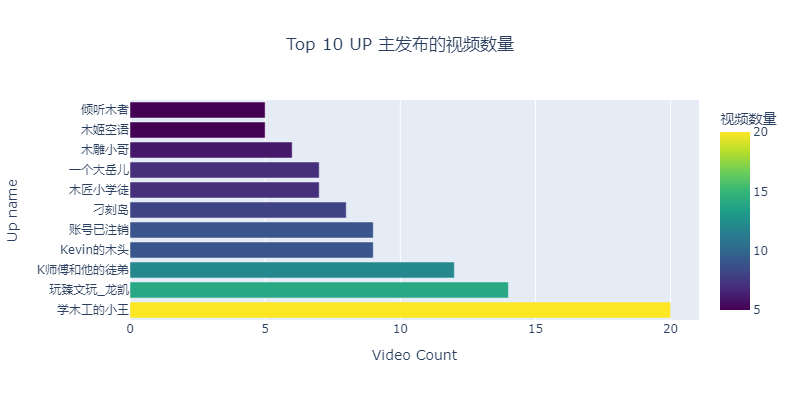

In [43]:
fig2 = px.bar(
    up_count,
    x="video_count",
    y="Up",
    orientation="h",  # 横向条形图
    title="Top 10 UP 主发布的视频数量",
    labels={"video_count": "视频数量", "Up": "UP 主"},
    color="video_count",  # 根据视频数量改变颜色
    color_continuous_scale="viridis"  # 使用 viridis 色彩
)
fig2.update_layout (
    width = 800, height = 400,
    xaxis_title = "Video Count", yaxis_title = "Up name",
    title_x = 0.5
)
fig2.show('png')

### Finding:
1. There are **424 wood carving videos** posted by **269 authors**.
2. The author with the most posted videos published 20 videos (学木工的小王).
3. Since the handmade wood carving artworks usually take long time to finish, the frequency of publishing related videos is low.

### 3.3 Influential Level of video authors

In [51]:
up_avg_like = pd.DataFrame(raw_data.groupby("Up")["点赞量"].mean()).reset_index()
up_avg_like

,Up,点赞量
0,1NJ2,0.0
1,21世纪经济报道视频,2.0
2,Chikizzzzzz,14.0
3,CleoYangProject,90.0
4,Cris14gsh,60.0
...,...,...
264,饿入托,3.0
265,馨泽世界鍺,77.0
266,高清视频素材精选,24.0
267,麟K,1.0


In [53]:
pd.merge(up_video_count, up_avg_like, on="Up", how="left").sort_values(by="点赞量",ascending=False).head(11)

,Up,video_count,点赞量
3,Kevin的木头,9,136995.111111
9,木姬空语,5,106269.400000
35,只看艺眼,2,74060.000000
155,二更视频,1,53000.000000
58,竹木技艺大师,1,46000.000000
31,诸葛舌头,2,34861.500000
256,三国杀,1,33000.000000
2,K师傅和他的徒弟,12,27735.583333
76,霓守艺小武哥,1,23000.000000
7,一个大岳儿,7,20668.571429


### Finding:
1. Only **2 authors** achieved 100K+ likes on average, and top 10 authors got over 20K+ likes.

### 3.4 Annual Growth Trend of Wood Carving Culture Heritage Videos

In [57]:
video_by_year = pd.DataFrame(raw_data.groupby("Publish Year").size()).reset_index()
video_by_year.columns = ["Publish Year", "Count by Year"]
video_by_year

,Publish Year,Count by Year
0,2016,1
1,2017,9
2,2018,6
3,2019,15
4,2020,25
5,2021,57
6,2022,81
7,2023,83
8,2024,92
9,2025,55


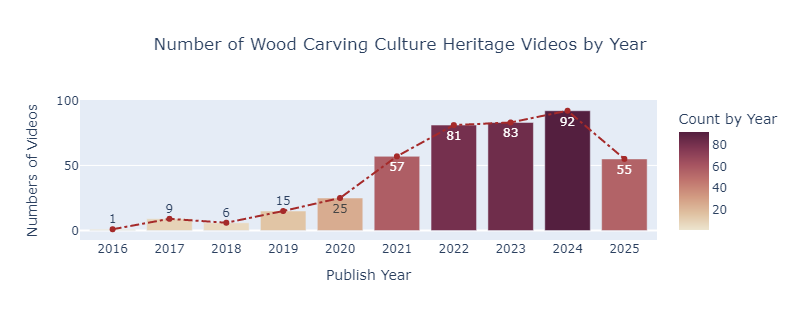

In [59]:
fig3 = px.bar(
    video_by_year,
    x = "Publish Year",
    y = "Count by Year",
    color = "Count by Year",
    color_continuous_scale = px.colors.sequential.Brwnyl,
    title = "Number of Wood Carving Culture Heritage Videos by Year",
    text = "Count by Year"
)

# add trend line on the bar chart
fig3.add_trace(
    go.Scatter(
        x = video_by_year["Publish Year"],
        y = video_by_year["Count by Year"],
        mode = "lines+markers",
        line = dict(color="brown", dash="dashdot"),
        name = "Video Count"
    )
)

fig3.update_layout(
    height = 320,
    width = 800,
    title_x = 0.5,
    yaxis_title = "Numbers of Videos",
    showlegend = False,
    xaxis = dict(tickvals=list(range(2016,2026))),
)

fig3.show('png')

### Finding:
1. According to the bar chart and the line chart, **the earlist** wood carving culture heritage video on Bilibili platform was published **in 2016**, and the number of the videos has **continuously increased since 2018**.
    - **Background Information**: In 2018, the Ministry of Culture and Tourism identified the fifth batch of national intangible culture heritage representative projects, including wood carving culture.
    - [Reference](https://www.mct.gov.cn/whzx/bnsj/fwzwhycs/201902/t20190212_837272.html)
2. In **2021**, the number of intangible culture heritage of wood carving videos **significantly increased**.
    - **Background Inforamtion**: In 2021, the Chinese government issued *"Opinions on Further Strengthening the protection of intangible cultural heritage"*(《关于进一步加强非物质文化遗产保护工作的意见》), which **standardice and improve the promotion of wood carving culture**. This policy helped intangible culture heritage to adapt the trend of deep media integration, enrich dissemination method, and expand communication channels.
    - [Reference](https://www.gov.cn/zhengce/2021-08/12/content_5630974.htm)

### 3.5 Seasonalnality of Wood Carving Culture Heritage Growth

In [63]:
video_by_month = pd.DataFrame(raw_data.groupby("Publish Month").size()).reset_index()
video_by_month.columns = ["Publish by Month", "Count by Month"]
video_by_month

,Publish by Month,Count by Month
0,1,39
1,2,43
2,3,53
3,4,22
4,5,35
5,6,25
6,7,35
7,8,41
8,9,29
9,10,28


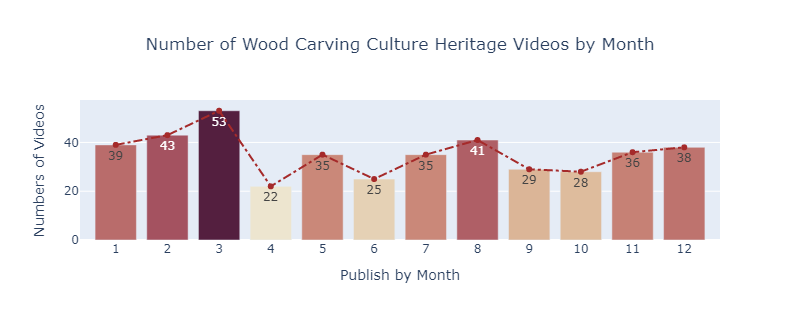

In [65]:
fig4 = px.bar(
    video_by_month,
    x = "Publish by Month",
    y = "Count by Month",
    color = "Count by Month",
    color_continuous_scale = px.colors.sequential.Brwnyl,
    title = "Number of Wood Carving Culture Heritage Videos by Month",
    text = "Count by Month"
)

fig4.add_trace(
    go.Scatter(
        x = video_by_month["Publish by Month"],
        y = video_by_month["Count by Month"],
        mode = "lines+markers",
        line = dict(color="brown", dash="dashdot"),
        name = "Video Count"
    )
)

fig4.update_layout(
    height = 320,
    width = 800,
    title_x = 0.5,
    yaxis_title = "Numbers of Videos",
    showlegend = False,
    coloraxis_showscale = False,
    xaxis = dict(tickvals=list(range(1,13))),
)

fig4.show('png')

### Finding
1. We detected an **increasing trend** of video posts *from Nov. to Mar.*
2. *Additional background information*: wood carving artworks are usually carved in fall and winter seasons (Sept to Feb), **when the climate is dry, and the wood is in the stable state.**
3. Conserdering the time it takes to complete the wood carving pieces and edit the videos, this is why most wood carving videos are posted from Nov. to Mar.

### 3.6 Dissemination Rate of Wood Carving Culture Heritage Videos

In [69]:
raw_data["recommend_rate"]

0      13248.333333
1       2702.000000
2         29.166667
3       8021.666667
4       4139.500000
           ...     
419     3108.000000
420       17.000000
421     1989.166667
422      391.166667
423       59.833333
Name: recommend_rate, Length: 424, dtype: float64

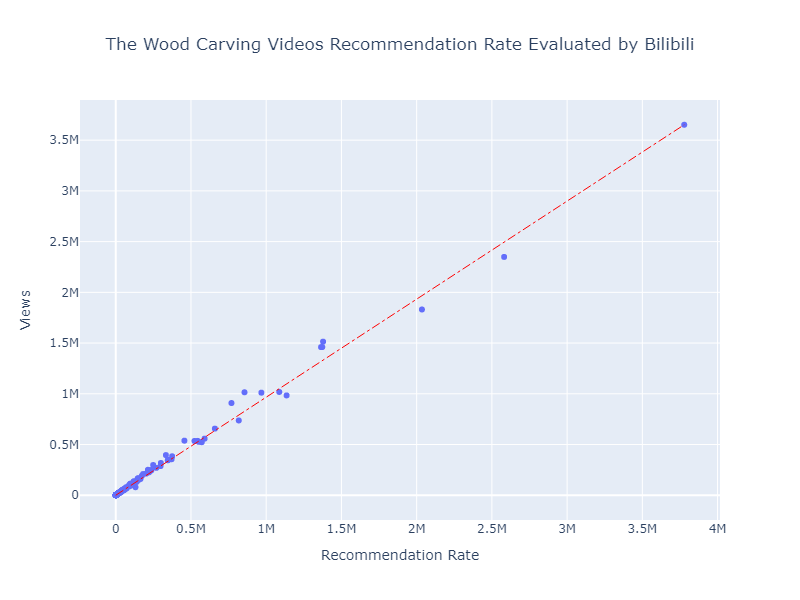

In [71]:
fig5 = px.scatter (
    data_frame = raw_data,
    x = "recommend_rate", 
    y = "播放量",
    title = "The Wood Carving Videos Recommendation Rate Evaluated by Bilibili",
    hover_data = ["Title", "Up"]
)

fig5.add_shape(
    type="line",
    x0=0, y0=0,
    x1=raw_data["recommend_rate"].max(),
    y1=raw_data["播放量"].max(),
    line = dict(color="red", dash="dashdot",width=1),
)

fig5.update_layout (
    width = 800, height = 600,
    xaxis_title = "Recommendation Rate", yaxis_title = "Views",
    title_x = 0.5
)
fig5.show('png')

### Finding:
1. Based the evaluation algorithm of Bilibili recommendation system, the wood carving videos that will be recommended are those that have already received the most views. This indicates that **even the most popular** niche culture videos are **still undervalued**.

### Reusable Function: Generate Corpus

In [80]:
'''
date: April 19 2025
@ author: Susan Sun
-function: To generate corpus from a text column in a dataframe.
-parameters:
    - df: a pandas dataframe
    - col: a String, name of the text column
-return:
    - token_df: a pandas dataframe contains tokens, frequencies, and word counts
'''
def generate_corpus (df, col):
    import jieba
    '''get topics from the videos titles'''
    corpus = []
    for (text) in df[col]:
        words = list(jieba.cut_for_search(text))
        corpus.extend(words)
        
    '''count frequency of each bigrams'''
    from collections import Counter 
    token_count = dict(Counter(corpus))
    token_df = pd.DataFrame(token_count.items(),columns=["token","frequency"])
    token_df["word count"] = token_df["token"].apply(lambda x: len (x))
    token_df = token_df[(token_df["word count"]>1) & (token_df["frequency"]>5)]
    token_df = token_df.sort_values(by="frequency",ascending=False).reset_index(drop=True)

    return token_df

### 3.7 Text Analysis on Key Words in the Video Titles

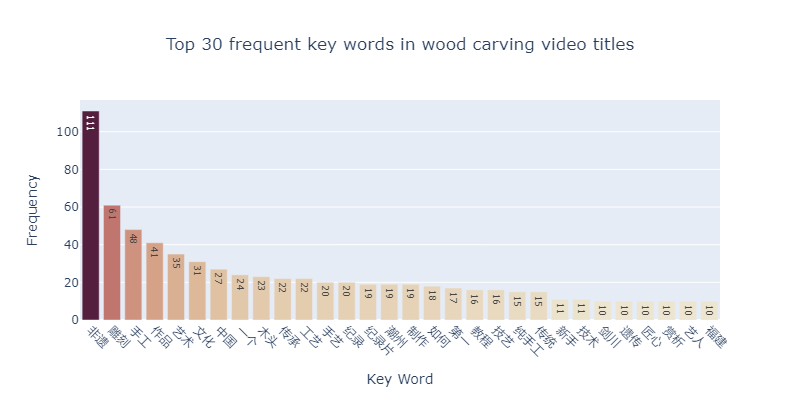

In [83]:
token_df = generate_corpus(df = raw_data, col = "Title").iloc[1:31]

fig5 = px.bar(
    token_df,
    x = "token",
    y = "frequency",
    color = "frequency",
    color_continuous_scale = px.colors.sequential.Brwnyl,
    title = "Top 30 frequent key words in wood carving video titles",
    text = "frequency"
)


fig5.update_layout(
    height = 400,
    width = 800,
    title_x = 0.5,
    xaxis_title = "Key Word",
    xaxis_tickangle = 45,
    yaxis_title = "Frequency",
    showlegend = False,
    coloraxis_showscale = False,
)

fig5.show('png')

### Finding:
- In addition to the search key word **"intangible wood carving culture"**, the titles of these videos also include key words, such as **"China", "Handmade","Art", "inheritage", "Tradition", and "Craftsmanship"**. This indicates that those key words may also attract people who are interested in *the overall intangible culture heritage* and *traditional Chinese crafts*, driving people's attentions to **niche culture**.

### 3.8 Explore the Commercial Promotion of Wood Carving Culture

In [87]:
raw_data["Title"].str.contains("合作|联名|同款|广告|推广|钱|买|卖|商品").mean()

0.01179245283018868

### Finding:
- The **commercialization level** of intangible wood carving culture heritage videos is **quite low**, with only **1.18%** of the videos containing words such as "buy","sell","commodity", "products", and "ads".
- According to the report of industrial development and commercial operation of intangible culture heritage, culture products such as clay sculpture, folk art, embroidery, and wood carving can enter the market. While ensuring the seriousness and the authenicity this kind of culture, appropriate commercial operation may bring more positive development and descentation to the wood carving art.
- [Reference](https://hhwhy.lzu.edu.cn/c/202312/200.html)

### 3.9 Compare Wood Carvings across Regions in China

In [99]:
chaozhou = raw_data[raw_data["Title"].str.contains("潮州|广东")]
print(f"count of chaozhou wood carving videos: {len(chaozhou)}")
print("average likes for chaozhou videos:",round(chaozhou["点赞量"].mean()))

fujian = raw_data[raw_data["Title"].str.contains("莆田|福建")]
print(f"count of fujian wood carving videos: {len(fujian)}")
print("average likes for fujian videos:", round(fujian["点赞量"].mean()))

anhui = raw_data[raw_data["Title"].str.contains("安徽|徽州")]
print(f"count of anhui wood carving videos: {len(anhui)}")
print("average likes for anhui videos:", round(anhui["点赞量"].mean()))

dongyang = raw_data[raw_data["Title"].str.contains("东阳|浙江")]
print(f"count of dongyang wood carving videos: {len(dongyang)}")
print("average likes for dongyang videos:", round(dongyang["点赞量"].mean()))

jianchuan = raw_data[raw_data["Title"].str.contains("剑川|云南")]
print(f"count of jianchuan wood carving videos: {len(jianchuan)}")
print("average likes for jianchuan videos:", round(jianchuan["点赞量"].mean()))

count of chaozhou wood carving videos: 19
average likes for chaozhou videos: 30
count of fujian wood carving videos: 16
average likes for fujian videos: 55
count of anhui wood carving videos: 3
average likes for anhui videos: 28
count of dongyang wood carving videos: 8
average likes for dongyang videos: 5796
count of jianchuan wood carving videos: 9
average likes for jianchuan videos: 969


### Comparison of Wood Carving Videos across Regions in China
|Region|Video Count|Average Video Likes|
|:-------------------------------------|----------------:|--------------:|
|Chaozhou,Guangdong|19|30|
|Putian,Fujian|16|55|
|Huizhou,Anhui|3|28|
|Dongyang,Zhejiang|8|**5796**|
|Jianchuan,Yunnan|9|969

Finding:
- Among five major regions of wood carving heritage, **Dongyang is with the most average likes**, becuase Dongyang wood carving collaborated with the game *"Three Kingdoms"* and movie *"Investiture of the Gods"* to produce **themed wood carving works**.
- Additionally, **Jianchuan is with second the most average likes**, because the video publishers of Jianchuan wood carving works are mainly **official political and tourism accounts**.
- This indicates that apporiate **commercial promotion** will bring more fans from other fields, while the **government official promotion** can increase the credibility and authority of the videos.

# Project Summary
## Goal
- To analyze the promotion and dissemination of intengible wood carving culture heritage on Chinese social media platform.
- To investigate the growth trend of public's attention to intengible wood carving culture heritage.
- To explore the recommendation mechanism of the video platform for specific culture.
## Data Set
- **Data Source**: Developed a **reusable scraper** algorithm to crawl the data from Bilibili, a Chinese video platform.
- **Data Description**: 424 wood carving culture heritage videos posted by 269 video authors, including general video information(title, pulished date, and author, etc.) and audience interaction data(like, coins, and shares etc.).
## Data Cleaning & Feature Engineering
- Cleaned the raw data by filtering irrelevant contents, detecting abnormal values, dropping duplicates, standardizing units, and unifing data types.
- Generated new features based on existed variables, including "published year" and "publish month" for later analysis on peak periods of wood carving culture promotion.
- Calculate "recommend rate" based on metrics of audience interactions and the platform recommend algorithm.
## Exploratory Data Analysis
- Applied **Plotly interactive scatter plot** to visualize **"The Relationship Between Likes/Views/Coins and Video Duration"** for all wood carving culture videos.
- Detected the **"Top 10 Video Authors of Wood Carving Culture Heritage Vidoes"**, using **Plotly bar chart** to see who are promoting this niche culture, and identified the **influencial levels of these authors** by calculating average likes of their videos.
- Explored **Annual Growth Trend of Wood Carving Culture Heritage Videos** by counting the number of videos posted each year, and **investigated the seasonalnality of wood carving making**.
- **Evaluated the recommendation rate** of wood carving culture heritage videos based on Bilibili recommendation algorithm.
- Conducted **text analysis** on video titles using *jieba* package to **generate corpus**, and **created bi-grams to find the most frequent key words** in wood carving videos.
- **Explored the commercialization level** of intengible wood carving culture to see its possibility of entering the market.
## Findings
- Find them in the documentations.